## imports

In [72]:
import chex
import gymnax
import imageio
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
import pickle
from ppo import ActorCritic, Transition
from typing import List, Any
from utils import load_checkpoint
from wrappers import LogWrapper, FlattenObservationWrapper

## set-up

In [64]:

######################
# settings
run_name = "ppo_4rooms_det" # "ppo_"cartpole
save_step = 49648 #49660  # 498724 # 49660
checkpoint = f"checkpoints/{run_name}_{save_step}.flax"
with open(f"configs/{run_name}_config.pkl", "rb") as f:
  config = pickle.load(f)
config["NUM_ENVS"] = 1
# environment setup
print(f"Loading {config['ENV_NAME']} environment.")
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)
# agent setup
print(f"Initializing agent from checkpoint.")
agent = ActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
checkpoint_dict = load_checkpoint(checkpoint, agent)
agent_params = checkpoint_dict["params"]

Loading FourRooms-misc environment.
Initializing agent from checkpoint.


## run

In [ ]:
######################
# Run evaluation

# INIT ENV
rng = jax.random.PRNGKey(30)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

# COLLECT TRAJECTORIES
def _env_step(runner_state, unused):
    agent_params, env_state, last_obs, rng = runner_state

    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    pi, value = agent.apply(agent_params, last_obs)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)

    # STEP ENV
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, config["NUM_ENVS"])
    obsv, env_state, reward, done, info = jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(rng_step, env_state, action, env_params)
    transition = Transition(
        done, action, value, reward, log_prob, last_obs, info
    )
    runner_state = (agent_params, env_state, obsv, rng)
    return runner_state, transition

runner_state = (agent_params, env_state, obsv, _rng)

# returns final runner_state tuple, and traj_batch is a Transition containting
# action, obs, reward, done, log_prob, value, info, each of which is
# (T, NUM_ENVS, ...)
# info is dict_keys(['discount', 'returned_episode', 'returned_episode_lengths', 
#                    'returned_episode_returns', 'timestep'])
num_steps = 500 # config["NUM_STEPS"]
runner_state, traj_batch = jax.lax.scan(
    _env_step, runner_state, None, num_steps
)

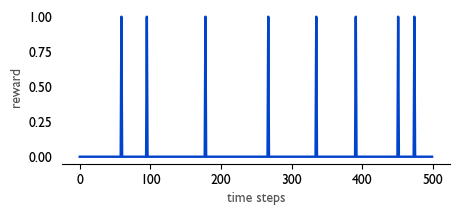

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
axs = [ax]
axs[0].plot(np.array(traj_batch.reward).astype(int).flatten())
axs[0].set_xlabel("time steps")
axs[0].set_ylabel("reward")
axs[0].grid(False)
plt.show()

## utilities

In [61]:
def generate_env_states(traj_obs: chex.Array, env_state_cls: Any) -> List[Any]:
  # Generates a list of env states created from the trajectory observations.
  # Assumes n_envs == 1.
  traj_obs = traj_obs[:, 0, :]  # [T, 1, ...] -> [T, ...]
  T, D = traj_obs.shape
  env_states = []
  for t in range(T):
    if "rooms" in str(env_state_cls).lower():
      pos, goal = traj_obs[t, :D//2], traj_obs[t, D//2:]
      env_states.append(env_state_cls(pos, goal, t))
    elif "cartpole" in str(env_state_cls).lower():
      x, x_dot, theta, theta_dot = traj_obs[t, :]
      env_states.append(env_state_cls(x, x_dot, theta, theta_dot, t))
    else:
      raise NotImplementedError("Env class not supported - " + str(env_state_cls).lower())

  return env_states

def unvectorize_env_state(env_state):
  # un-vectorize environment state (assumes n_envs == 1)
  new_attributes = []
  for _, v in vars(env_state.env_state).items():
    new_attributes.append(v[0])

  unvectorized_state = type(env_state.env_state)(*new_attributes)
  return unvectorized_state

base_env = lambda env: env._env._env

# make a gif
def make_gif(gif_name: str, env: Any, env_params: Any, env_states: List[Any], frame_duration: float = 0.5) -> List[Any]:
  filenames = []
  if not hasattr(base_env(env), "render"):
    raise NotImplementedError("Env does not have render method.")
  for t, env_state in enumerate(env_states):
    fig, _ = base_env(env).render(env_state, env_params)
    fig.canvas.draw()
    filename = f"temp_frame_{t}.png"
    plt.savefig(filename)
    filenames.append(filename)
    # plt.show()
    plt.close(fig)

  # Build GIF
  with imageio.get_writer(f"gifs/{gif_name}", mode='I', duration=frame_duration) as writer:
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)

  # Remove files
  for filename in set(filenames):
    os.remove(filename)

## plot stuff

In [67]:
traj_env_states = generate_env_states(traj_batch.obs, type(env_state.env_state))

In [68]:
make_gif("ppo_4rooms.gif", env, env_params, traj_env_states[:100], frame_duration=0.3)

/var/folders/fz/q04kwq096ts6wb65tk0dbk8h0000gn/T/ipykernel_21123/686593735.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

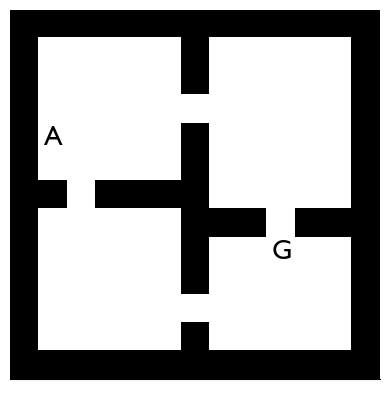

In [26]:
%matplotlib inline
unvectorized_env_state = unvectorize_env_state(env_state)
base_env(env).render(unvectorized_env_state, env_params)
